In [2]:
import pandas as pd
import requests
import json
import re, string, timeit
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
pd.set_option('display.max_colwidth', -1)

In [4]:
df1 = pd.read_csv('Sold_Properties.csv')
df1.shape

(183, 19)

In [5]:
df1.head()

,state,features,propertyType,bathrooms,bedrooms,carspaces,unitNumber,streetNumber,street,area,region,suburb,postcode,displayableAddress,latitude,longitude,landArea,id,sold_price
0,NSW,"['AirConditioning', 'BuiltInWardrobes', 'Ensuite', 'Gas', 'SecureParking', 'Intercom', 'BroadbandInternetAccess', 'Heating', 'Dishwasher', 'Shed', 'FullyFenced']",House,2,4,2,NaN,3.0,Yale Court,Albury - Greater Region,Regional NSW,THURGOONA,2640,"3 Yale Court, Thurgoona",-36.017563,147.014511,807,2016757756,485000
1,NSW,"['Ensuite', 'Gas', 'SwimmingPool', 'Heating', 'Shed', 'SolarHotWater']",House,2,4,4,NaN,148.0,Corrys Road,Albury - Greater Region,Regional NSW,THURGOONA,2640,"148 Corrys Road, Thurgoona",-36.054005,146.972600,4287,2016748075,700000
2,NSW,"['AirConditioning', 'Gas', 'SecureParking', 'Gym', 'Dishwasher', 'Shed', 'FullyFenced']",House,1,3,5,NaN,7.0,Erica Court,Albury - Greater Region,Regional NSW,THURGOONA,2640,"7 Erica Court, Thurgoona",-36.048378,146.980652,839,2016740271,400000
3,NSW,"['BuiltInWardrobes', 'Ensuite', 'Floorboards', 'SecureParking', 'Heating', 'SolarPanels']",House,2,4,2,NaN,33.0,Oxford Drive,Albury - Greater Region,Regional NSW,THURGOONA,2640,"33 Oxford Drive, Thurgoona",-36.020596,147.011139,803,2016723736,540000
4,NSW,['Shed'],House,1,3,2,NaN,2.0,Tawonga Place,Albury - Greater Region,Regional NSW,THURGOONA,2640,"2 Tawonga Place, Thurgoona",-36.053757,146.990112,1270,2016663170,272000


In [6]:
df1["sold_price"].describe()

count    1.830000e+02
mean     4.779006e+05
std      1.631545e+05
min      2.300000e+05
25%      3.700000e+05
50%      4.300000e+05
75%      5.537500e+05
max      1.200000e+06
Name: sold_price, dtype: float64

In [7]:
import plotly.express as px

fig = px.scatter_mapbox(df1, lat="latitude", lon="longitude", hover_name="id",size = "sold_price", hover_data=["propertyType", "bedrooms", "bathrooms", "landArea", "displayableAddress"],zoom=15, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [8]:
print("Median price: %f" % df1["sold_price"].median(),",","Mean price: %f" % df1["sold_price"].mean().round())
print("Skewness: %f" % df1["sold_price"].skew(),",", "Kurtosis: %f" % df1["sold_price"].kurt())

Median price: 430000.000000 , Mean price: 477901.000000
Skewness: 1.084919 , Kurtosis: 1.428688


<AxesSubplot:xlabel='landArea', ylabel='sold_price'>

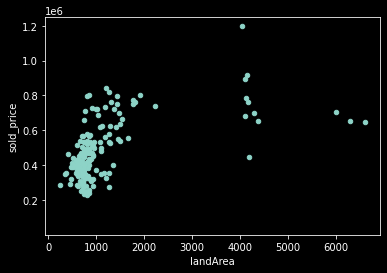

In [9]:
var = 'landArea'
df1.plot.scatter(x=var, y='sold_price', ylim=(0.800000))

<AxesSubplot:xlabel='landArea', ylabel='sold_price'>

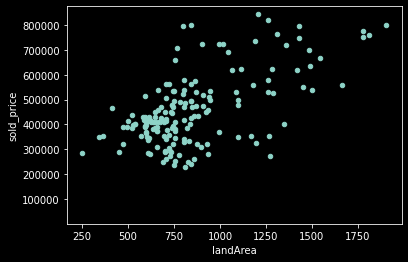

In [10]:
# Remove outliers
df1 = df1.drop(df1[df1['landArea'] >= 2000].index)
df1.plot.scatter(x=var, y='sold_price', ylim=(0.800000))


 mu = 456862.94 and sigma = 141470.62



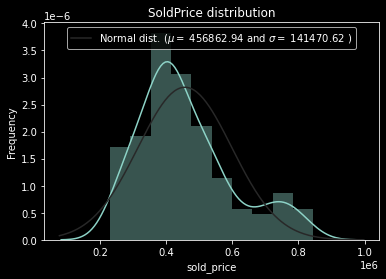

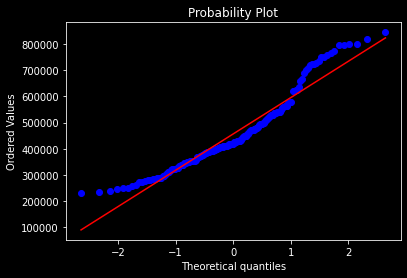

In [11]:
from scipy import stats
from scipy.stats import norm, skew
sns.distplot(df1.sold_price, fit=norm)
(mu, sigma) = norm.fit(df1['sold_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='upper center')
plt.ylabel('Frequency')
plt.title('SoldPrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df1['sold_price'], plot=plt)
plt.show()

In [12]:
data = df1.copy()

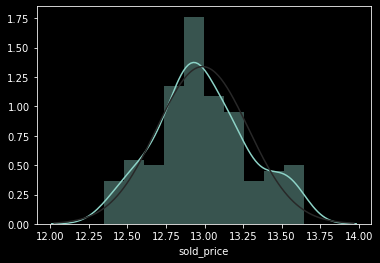

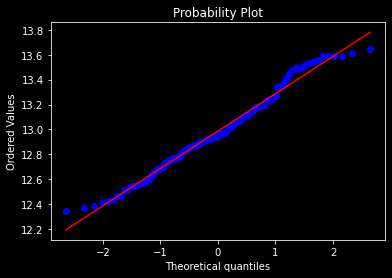

In [13]:
#applying log transformation
data['sold_price'] = np.log(data['sold_price'])
#transformed histogram and normal probability plot
sns.distplot(data['sold_price'], fit=norm);
fig = plt.figure()
res = stats.probplot(data['sold_price'], plot=plt)

In [14]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [15]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(data[['bedrooms','bathrooms','carspaces','landArea']], data['sold_price'])
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(127, 4) (127,) (43, 4) (43,)


Base models

In [17]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.2036 (0.0311)



In [18]:
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1)).fit(x_train, y_train)
lasso_preds = np.expm1(model_lasso.predict(x_test))
z = pd.Series(lasso_preds)
print(z.unique)

<bound method Series.unique of 0     461322.519638
1     378651.503090
2     509266.474180
3     253236.184345
4     529584.100143
5     342559.204711
6     436308.549137
7     437338.856277
8     352548.938938
9     276144.667123
10    268787.750821
11    445784.557622
12    439997.878564
13    780960.434216
14    366110.546717
15    450207.134160
16    438340.199121
17    439614.781607
18    279695.195905
19    269313.862567
20    233666.461056
21    431646.351039
22    278884.269892
23    509335.882852
24    269001.259560
25    489188.873947
26    430145.011345
27    521153.982113
28    429520.995370
29    431270.525566
30    429520.995370
31    466711.604304
32    493887.058967
33    421368.327394
34    448120.482596
35    461456.485351
36    487005.351325
37    542324.802233
38    692105.111348
39    456525.568265
40    440381.309365
41    443460.809136
42    371896.052080
dtype: float64>


In [19]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("\nEnet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



Enet score: 0.2036 (0.0311)



In [20]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("\nKRR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


KRR score: 0.2764 (0.1451)



In [83]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("\nGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


GBoost score: 0.2442 (0.0283)



In [84]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsle_cv(model_xgb)
print("\nmodel_xgb score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[17:33:04] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:33:05] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:33:05] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:33:06] WARNING: ..

In [85]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("\nmodel_lgb score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6

In [86]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11).fit(x_train, y_train)
lgb_preds = np.expm1(model_lgb.predict(x_test))
z = pd.Series(lgb_preds)
print(z.round(0).unique())

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[473247. 611621. 270962. 573938. 376548. 350189.]


In [87]:
# Define R2
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

In [88]:
df2 = pd.read_csv("ForSale_Properties.csv")
df2.head()

,state,features,propertyType,bathrooms,bedrooms,carspaces,unitNumber,streetNumber,street,area,region,suburb,postcode,displayableAddress,latitude,longitude,landArea,id,labels
0,NSW,"['Ensuite', 'Gas', 'SecureParking', 'Heating']",House,2,4,2,NaN,2,Sturt Place,Albury - Greater Region,Regional NSW,THURGOONA,2640,"2 Sturt Place, Thurgoona",-36.018143,147.015686,808,2016849141,-1
1,NSW,"['AirConditioning', 'BuiltInWardrobes', 'Ensuite', 'Gas', 'SecureParking', 'BroadbandInternetAccess', 'Heating', 'Dishwasher', 'Shed']",House,2,4,2,NaN,10,Lindisfarne Court,Albury - Greater Region,Regional NSW,THURGOONA,2640,"10 Lindisfarne Court, Thurgoona",-36.054200,146.997559,721,2016841907,0
2,NSW,"['BuiltInWardrobes', 'Ensuite', 'Floorboards', 'Gas', 'SecureParking', 'SwimmingPool', 'Bath', 'Heating', 'Dishwasher', 'Study', 'Shed', 'FullyFenced']",House,2,4,3,NaN,15,Gale Court,Albury - Greater Region,Regional NSW,THURGOONA,2640,"15 Gale Court, Thurgoona",-36.039530,147.003021,3093,2016819354,1
3,NSW,"['AirConditioning', 'BuiltInWardrobes', 'Ensuite', 'SecureParking', 'SwimmingPool', 'Heating', 'Study']",House,2,4,2,NaN,20,Whittler Road,Albury - Greater Region,Regional NSW,THURGOONA,2640,"20 Whittler Road, Thurgoona",-36.025080,146.985428,665,2016823788,-1
4,NSW,"['Ensuite', 'Gas', 'SecureParking', 'SwimmingPool', 'Gym', 'Heating', 'Shed', 'DoubleGlazedWindows', 'SolarPanels']",House,2,4,2,NaN,103,Forest Drive,Albury - Greater Region,Regional NSW,THURGOONA,2640,"103 Forest Drive, Thurgoona",-36.046596,147.008224,1380,2016382640,1


In [89]:
df2.shape

(28, 19)

In [90]:
X = df2[['bathrooms','bedrooms','carspaces','landArea']]
X.head()

(28, 4)

In [94]:
df2['Price (estimated)'] = np.expm1(model_lasso.predict(X))
df2['Price (estimated)'] = df2['Price (estimated)'].astype(int)
len(df2['Price (estimated)'].round(0).unique())

27

In [93]:
df2.head()

,state,features,propertyType,bathrooms,bedrooms,carspaces,unitNumber,streetNumber,street,area,region,suburb,postcode,displayableAddress,latitude,longitude,landArea,id,labels,Price (estimated)
0,NSW,"['Ensuite', 'Gas', 'SecureParking', 'Heating']",House,2,4,2,NaN,2,Sturt Place,Albury - Greater Region,Regional NSW,THURGOONA,2640,"2 Sturt Place, Thurgoona",-36.018143,147.015686,808,2016849141,-1,676111
1,NSW,"['AirConditioning', 'BuiltInWardrobes', 'Ensuite', 'Gas', 'SecureParking', 'BroadbandInternetAccess', 'Heating', 'Dishwasher', 'Shed']",House,2,4,2,NaN,10,Lindisfarne Court,Albury - Greater Region,Regional NSW,THURGOONA,2640,"10 Lindisfarne Court, Thurgoona",-36.054200,146.997559,721,2016841907,0,652388
2,NSW,"['BuiltInWardrobes', 'Ensuite', 'Floorboards', 'Gas', 'SecureParking', 'SwimmingPool', 'Bath', 'Heating', 'Dishwasher', 'Study', 'Shed', 'FullyFenced']",House,2,4,3,NaN,15,Gale Court,Albury - Greater Region,Regional NSW,THURGOONA,2640,"15 Gale Court, Thurgoona",-36.039530,147.003021,3093,2016819354,1,1813225
3,NSW,"['AirConditioning', 'BuiltInWardrobes', 'Ensuite', 'SecureParking', 'SwimmingPool', 'Heating', 'Study']",House,2,4,2,NaN,20,Whittler Road,Albury - Greater Region,Regional NSW,THURGOONA,2640,"20 Whittler Road, Thurgoona",-36.025080,146.985428,665,2016823788,-1,637560
4,NSW,"['Ensuite', 'Gas', 'SecureParking', 'SwimmingPool', 'Gym', 'Heating', 'Shed', 'DoubleGlazedWindows', 'SolarPanels']",House,2,4,2,NaN,103,Forest Drive,Albury - Greater Region,Regional NSW,THURGOONA,2640,"103 Forest Drive, Thurgoona",-36.046596,147.008224,1380,2016382640,1,855075
5,NSW,"['Ensuite', 'Gas', 'SecureParking', 'Heating']",House,2,4,2,NaN,36,Stockman Circuit,Albury - Greater Region,Regional NSW,THURGOONA,2640,"36 Stockman Circuit, Thurgoona",-36.055607,147.010635,925,2016798090,1,709379
6,NSW,"['BuiltInWardrobes', 'Ensuite', 'Gas', 'SecureParking', 'Bath', 'Heating', 'Dishwasher', 'Study', 'Shed', 'FullyFenced', 'SolarPanels']",House,2,4,3,NaN,101,Forest Drive,Albury - Greater Region,Regional NSW,THURGOONA,2640,"101 Forest Drive, Thurgoona",-36.046730,147.008667,935,2016816192,1,747628
7,NSW,"['Ensuite', 'Gas', 'SecureParking', 'SwimmingPool', 'Heating']",House,2,5,3,NaN,43,Hartigan Street,Albury - Greater Region,Regional NSW,THURGOONA,2640,"43 Hartigan Street, Thurgoona",-36.041466,146.986160,817,2016781446,0,989026
8,NSW,"['Ensuite', 'Gas', 'SecureParking', 'Bath', 'Heating', 'Dishwasher']",House,2,4,2,NaN,57,Fairway Gardens Road,Albury - Greater Region,Regional NSW,THURGOONA,2640,"57 Fairway Gardens Road, Thurgoona",-36.044422,147.007141,758,2016788918,1,662373
9,NSW,"['Ensuite', 'Gas', 'SecureParking', 'Heating', 'SolarPanels']",House,2,4,2,NaN,90,Honeyeater Circuit,Albury - Greater Region,Regional NSW,THURGOONA,2640,"90 Honeyeater Circuit, Thurgoona",-36.037678,146.980591,616,2016829918,0,624863


In [98]:
import plotly.express as px

fig = px.scatter_mapbox(df2, lat="latitude", lon="longitude", hover_name="id", color = "Price (estimated)", size = "landArea", hover_data=["propertyType", "bedrooms", "bathrooms", "displayableAddress"],zoom=15, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()